In [49]:
from importlib import reload
import pandas as pd
import numpy as np
import functions_preprocessing as f
reload(f)

<module 'functions_preprocessing' from 'e:\\Pima-Diabetes-Prediction\\notebooks\\functions_preprocessing.py'>

In [50]:
cases = {
    "drop_outliers":True,
    "balance_data":True,
    "scale_data":False,
}

# Data Loading

In [ ]:
df = pd.read_csv('../data/original.csv')

# Data Preprocessing


## Data Exploring

In [52]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [53]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Data Cleaning

The columns `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI` cannot have a value of 0. These values will be replaced with `NaN` and subsequently imputed.

In [55]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

In [56]:
df.duplicated().sum()

0

In [57]:
df.columns = df.columns.str.lower()

In [58]:
df.isna().sum()/len(df)*100

pregnancies                  0.000000
glucose                      0.651042
bloodpressure                4.557292
skinthickness               29.557292
insulin                     48.697917
bmi                          1.432292
diabetespedigreefunction     0.000000
age                          0.000000
outcome                      0.000000
dtype: float64

## Data Visualization

In [59]:
num_features = df.drop(columns='outcome').select_dtypes(include=['number']).columns
float_features = df.drop(columns='outcome').select_dtypes(include=['float64']).columns
int_features = df.drop(columns='outcome').select_dtypes(include=['int64']).columns
target = 'outcome'

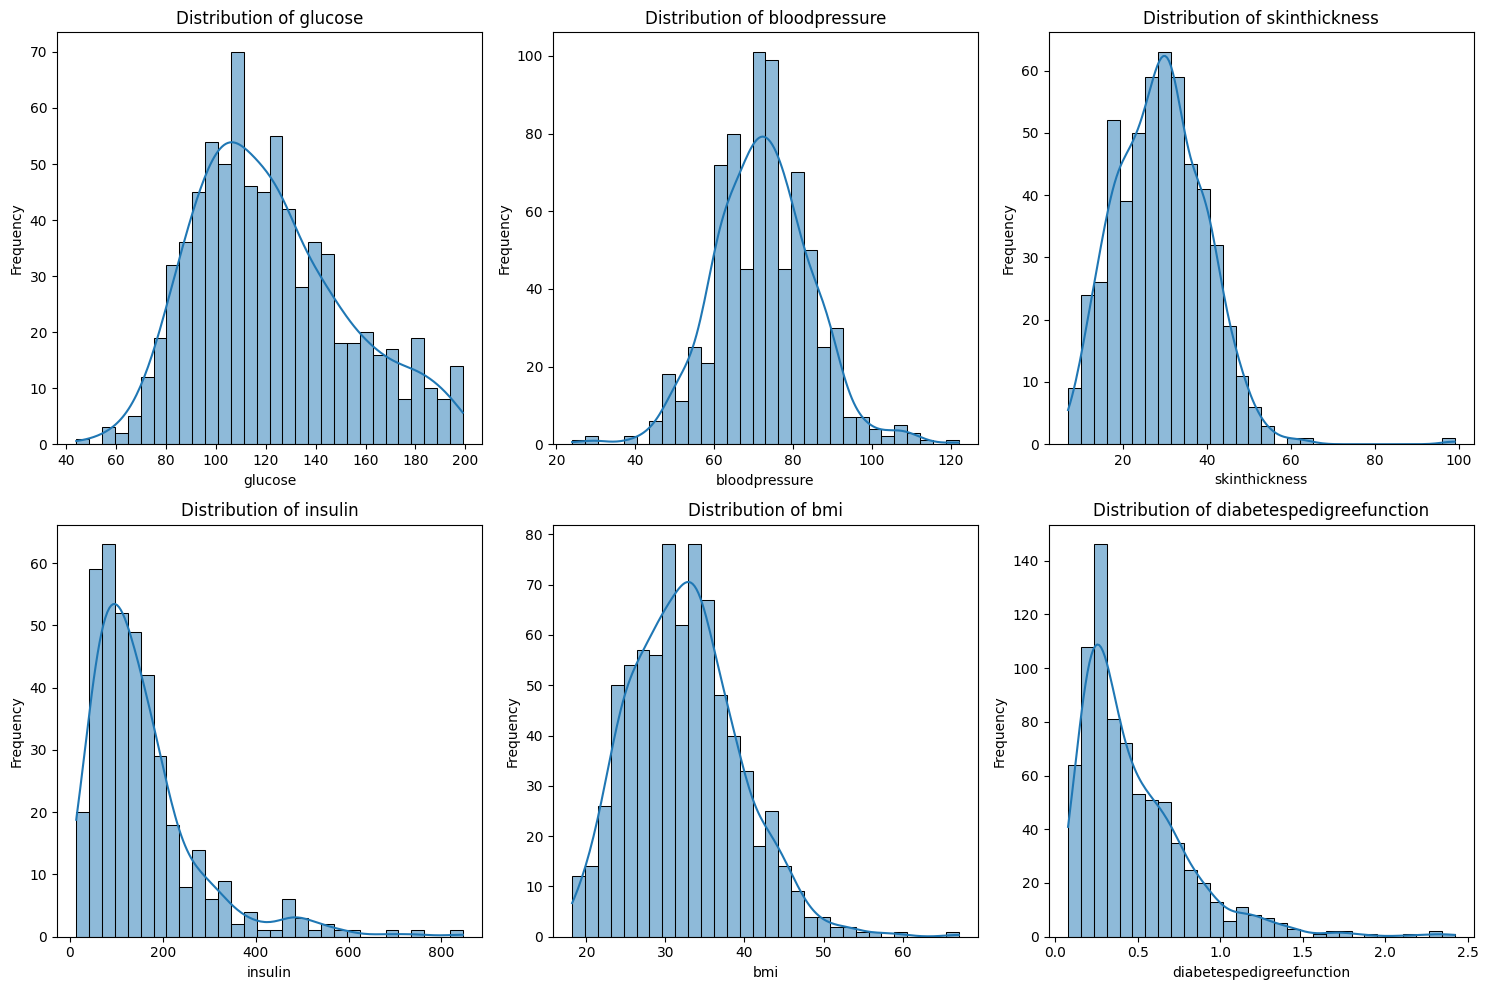

In [60]:
f.plot_histogram(df, float_features)

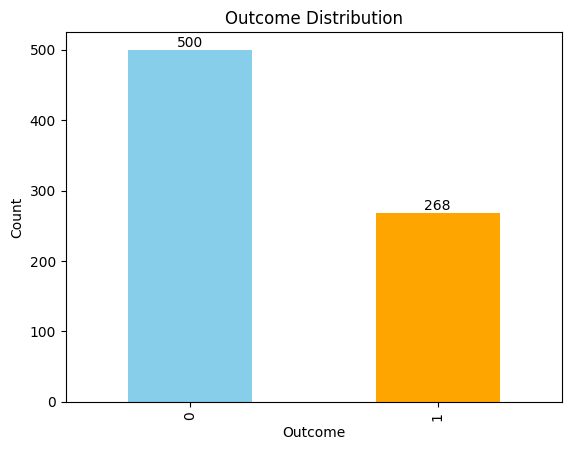

In [61]:
f.plot_target_distribution(df, target)

## Missing Values Imputation

In [62]:
imputer_recommendations = f.imputer_recommender(df, num_features, soft=True, display_info=False, threshold_null=0.5)

,Column,Recommendation
0,glucose,SimpleImputer: strategy='median'
1,bloodpressure,SimpleImputer: strategy='median'
2,skinthickness,Iterative Imputer (Better for high correlations)
3,insulin,SimpleImputer: strategy='median'
4,bmi,Iterative Imputer (Better for high correlations)


In [63]:
df = f.apply_imputer_strategy(df, imputer_recommendations)

🔧 Aplicando SimpleImputer(median) en: ['glucose', 'bloodpressure', 'insulin']
🔧 Aplicando IterativeImputer(max_iter=10) en: ['skinthickness', 'bmi']


## Outlier Handling

In [64]:
if cases["drop_outliers"]:
    f.outlier_handling_detect_all(df, num_features, remove=True)

## Data Balancing

In [65]:
balancing_recomendation = f.data_balancing_oversampling_recommender(df.drop(columns='outcome'), df['outcome'], soft=False)

🧠 Advanced dataset diagnosis:
--------------------------------------------------
🎯 Classes: {1: 242, 0: 488}
📉 Minority class: '1' (33.15%) → ⚠️ Moderate
🔢 Numerical variables: 8 | 🔠 Categorical: 0
📈 Multimodal: 0/8
↩️ Skewed: 0/8
🔺 Leptokurtic: 0/8
📉 Non-normal: 7/8
📦 Low variance: 0/8
⚠️ Outlier ratio (IQR & Z-Score) in the minority class: 23.97%
--------------------------------------------------
✅ Recommendation: KMeansSMOTE
💡 Reason: High proportion of outliers detected in the minority class


In [66]:
if cases["balance_data"]:
    df = f.apply_balancing_oversampling(df.drop(columns='outcome'), df['outcome'], balancing_recomendation)
else:
    "No data balancing was applied"

✅ KMeansSMOTE aplicado exitosamente.


In [67]:
if cases["balance_data"]:
    df = f.apply_balancing_oversampling(df.drop(columns='outcome'), df['outcome'], recommendation="RandomOverSampler", target_counts={0: 500, 1: 500})
else:
    "No data balancing was applied"

✅ RandomOverSampler aplicado exitosamente.


## Feature Selection

### Numerical Features -> Categoric Target

#### ANOVA | Kruskal-Wallis

In [72]:
f.feature_selection_anova_kruskal(df, num_features, target, display_info=True)

,Test Used,F-Statistic,P-Value,Impact
Feature,,,,
pregnancies,ANOVA (parametric),48.506346,5.965803e-12,True
glucose,ANOVA (parametric),698.904072,3.642666e-117,True
bloodpressure,ANOVA (parametric),68.358178,4.317067e-16,True
skinthickness,ANOVA (parametric),73.108487,4.557252e-17,True
insulin,ANOVA (parametric),21.853475,3.346567e-06,True
bmi,ANOVA (parametric),124.725910,2.267553e-27,True
diabetespedigreefunction,ANOVA (parametric),23.655966,1.337670e-06,True
age,ANOVA (parametric),94.854949,1.786500e-21,True


All float features significantly impact the target variable; therefore, no columns are dropped.

#### Mutual Information Categorical

In [73]:
f.feature_selection_mutual_info_categ(df, num_features, target, soft=False, display_info=True)

,Mutual_Info,Impact
Feature,,
pregnancies,0.037352,False
glucose,0.254041,True
bloodpressure,0.156299,True
skinthickness,0.126477,True
insulin,0.095566,False
bmi,0.101823,True
diabetespedigreefunction,0.051125,False
age,0.068360,False


In several instances, when executing the `mutual_info_categ` function, the output indicates that the impact is either low or moderate. Therefore, I will explore an alternative technique to gain more insights.

### Categoric Features -> Categoric Target

## Feature Transformation

## Feature Encoding

## Feature Scaling

In [74]:
suggest_transform = f.feature_scaling_recommender(df, num_features, soft=True, display_info=False)

,Column,Recommendation
0,pregnancies,MinMaxScaler
1,glucose,StandardScaler
2,bloodpressure,RobustScaler
3,skinthickness,StandardScaler
4,insulin,MinMaxScaler
5,bmi,StandardScaler
6,diabetespedigreefunction,MinMaxScaler
7,age,MinMaxScaler


In [75]:
if cases["scale_data"]:
    df = f.apply_scaling_transform(df, suggest_transform)
else:
    "No data scaling was applied"

In [76]:
print(f"This dataset { '' if cases['drop_outliers'] else 'does not '}have outliers removed")
print(f"This dataset { '' if cases['balance_data'] else 'does not '}have balanced data")
print(f"This dataset { '' if cases['scale_data'] else 'does not '}have scaled data")
df

This dataset have outliers removed
This dataset have balanced data
This dataset does not have scaled data


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148.000000,72.000000,35.000000,125.0,33.600000,0.627000,50,1
1,1,85.000000,66.000000,29.000000,125.0,26.600000,0.351000,31,0
2,8,183.000000,64.000000,19.688009,125.0,23.300000,0.672000,32,1
3,1,89.000000,66.000000,23.000000,94.0,28.100000,0.167000,21,0
4,5,116.000000,74.000000,21.959733,125.0,25.600000,0.201000,30,0
...,...,...,...,...,...,...,...,...,...
995,0,150.593788,89.819461,45.735219,125.0,42.185756,0.383367,21,1
996,0,189.000000,104.000000,25.000000,125.0,34.300000,0.435000,41,1
997,5,116.000000,74.000000,29.000000,125.0,32.300000,0.660000,35,1
998,1,95.000000,82.000000,25.000000,180.0,35.000000,0.233000,43,1
